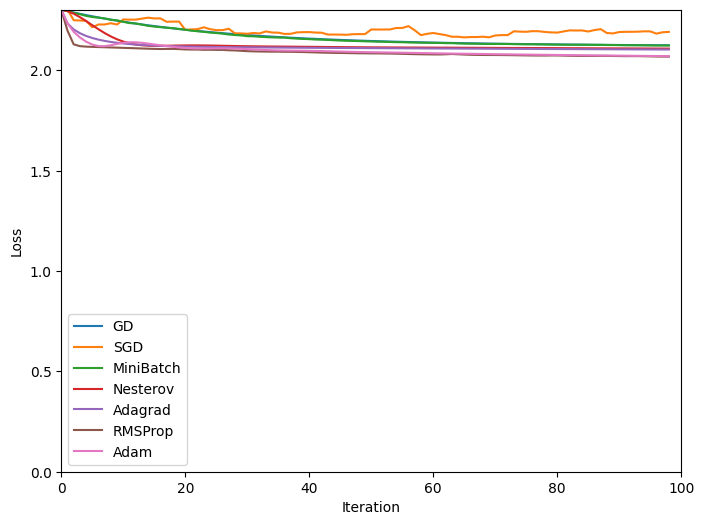

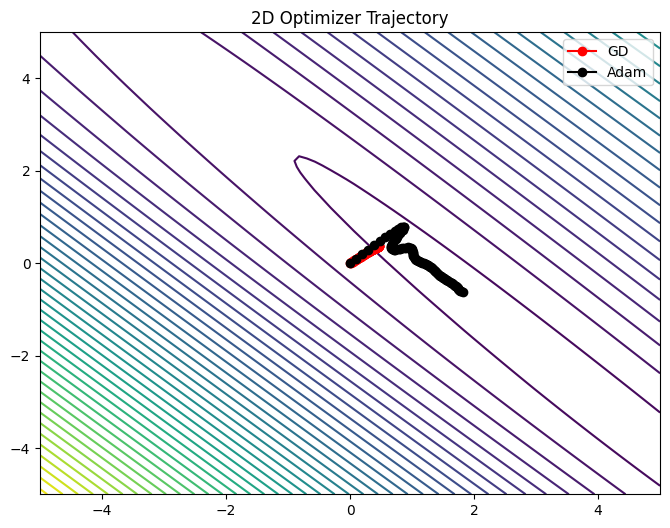

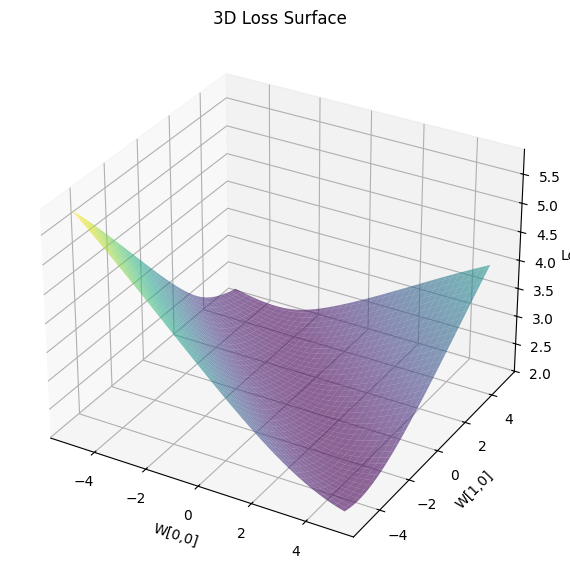

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from tensorflow.keras.datasets import mnist

# ==============================
# Load MNIST
# ==============================
(X_train, y_train), _ = mnist.load_data()

# Use smaller subset for faster CPU execution
X_train = X_train[:5000]
y_train = y_train[:5000]

# ==============================
# Feature Extraction (2 features)
# ==============================
def extract_features(X):
    f1 = np.mean(X, axis=(1,2))
    f2 = np.std(X, axis=(1,2))
    return np.column_stack((f1, f2))

X_train_feat = extract_features(X_train)

# Normalize
mean = np.mean(X_train_feat, axis=0)
std = np.std(X_train_feat, axis=0)
X_train_feat = (X_train_feat - mean) / std

# One-hot encoding
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train)

# ==============================
# Softmax + Loss + Gradient
# ==============================
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def compute_loss(X, y, W):
    logits = X @ W
    probs = softmax(logits)
    return -np.sum(y * np.log(probs + 1e-8)) / X.shape[0]

def compute_gradient(X, y, W):
    logits = X @ W
    probs = softmax(logits)
    return (X.T @ (probs - y)) / X.shape[0]

learning_rate = 0.1
iterations = 100
initial_W = np.zeros((2,10))

# ==============================
# Optimizers
# ==============================

def gradient_descent(X, y):
    W = initial_W.copy()
    history = []
    for i in range(iterations):
        loss = compute_loss(X, y, W)
        history.append((W.copy(), loss))
        grad = compute_gradient(X, y, W)
        W -= learning_rate * grad
    return W, history


def sgd(X, y):
    W = initial_W.copy()
    history = []
    n = len(y)
    for i in range(iterations):
        loss = compute_loss(X, y, W)
        history.append((W.copy(), loss))
        idx = np.random.randint(0, n)
        grad = compute_gradient(X[idx:idx+1], y[idx:idx+1], W)
        W -= learning_rate * grad
    return W, history


def mini_batch(X, y, batch_size=64):
    W = initial_W.copy()
    history = []
    n = len(y)
    for i in range(iterations):
        loss = compute_loss(X, y, W)
        history.append((W.copy(), loss))
        idx = np.random.choice(n, batch_size, replace=False)
        grad = compute_gradient(X[idx], y[idx], W)
        W -= learning_rate * grad
    return W, history


def nesterov(X, y, momentum=0.9):
    W = initial_W.copy()
    V = np.zeros_like(W)
    history = []
    for i in range(iterations):
        loss = compute_loss(X, y, W)
        history.append((W.copy(), loss))
        lookahead = W - momentum * V
        grad = compute_gradient(X, y, lookahead)
        V = momentum * V + learning_rate * grad
        W -= V
    return W, history


def adagrad(X, y):
    W = initial_W.copy()
    G = np.zeros_like(W)
    history = []
    eps = 1e-8
    for i in range(iterations):
        loss = compute_loss(X, y, W)
        history.append((W.copy(), loss))
        grad = compute_gradient(X, y, W)
        G += grad**2
        W -= learning_rate * grad / (np.sqrt(G) + eps)
    return W, history


def rmsprop(X, y, beta=0.9):
    W = initial_W.copy()
    E = np.zeros_like(W)
    history = []
    eps = 1e-8
    for i in range(iterations):
        loss = compute_loss(X, y, W)
        history.append((W.copy(), loss))
        grad = compute_gradient(X, y, W)
        E = beta * E + (1-beta) * grad**2
        W -= learning_rate * grad / (np.sqrt(E) + eps)
    return W, history


def adam(X, y):
    W = initial_W.copy()
    m = np.zeros_like(W)
    v = np.zeros_like(W)
    history = []
    beta1, beta2 = 0.9, 0.999
    eps = 1e-8
    for t in range(1, iterations+1):
        loss = compute_loss(X, y, W)
        history.append((W.copy(), loss))
        grad = compute_gradient(X, y, W)
        m = beta1*m + (1-beta1)*grad
        v = beta2*v + (1-beta2)*(grad**2)
        m_hat = m/(1-beta1**t)
        v_hat = v/(1-beta2**t)
        W -= learning_rate * m_hat/(np.sqrt(v_hat)+eps)
    return W, history


# ==============================
# Train All Optimizers
# ==============================

W_gd, hist_gd = gradient_descent(X_train_feat, y_train_oh)
W_sgd, hist_sgd = sgd(X_train_feat, y_train_oh)
W_mb, hist_mb = mini_batch(X_train_feat, y_train_oh)
W_nest, hist_nest = nesterov(X_train_feat, y_train_oh)
W_ada, hist_ada = adagrad(X_train_feat, y_train_oh)
W_rms, hist_rms = rmsprop(X_train_feat, y_train_oh)
W_adam, hist_adam = adam(X_train_feat, y_train_oh)

# ==============================
# Loss Curve Animation
# ==============================

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlim(0, iterations)
ax.set_ylim(0, max([h[1] for h in hist_gd]))

lines = {}
names = ["GD","SGD","MiniBatch","Nesterov","Adagrad","RMSProp","Adam"]
histories = [hist_gd,hist_sgd,hist_mb,hist_nest,hist_ada,hist_rms,hist_adam]

for name in names:
    lines[name], = ax.plot([], [], label=name)

ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.legend()

def update(frame):
    for name, hist in zip(names, histories):
        lines[name].set_data(range(frame), [h[1] for h in hist[:frame]])
    return list(lines.values())

ani = animation.FuncAnimation(fig, update, frames=iterations, interval=80)
HTML(ani.to_jshtml())

# ==============================
# 2D Contour Surface
# ==============================

w1_vals = np.linspace(-5,5,80)
w2_vals = np.linspace(-5,5,80)
W1, W2 = np.meshgrid(w1_vals, w2_vals)
Loss_surface = np.zeros_like(W1)

W_base = W_adam.copy()

for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        W_temp = W_base.copy()
        W_temp[0,0] = W1[i,j]
        W_temp[1,0] = W2[i,j]
        Loss_surface[i,j] = compute_loss(X_train_feat, y_train_oh, W_temp)

traj_gd = np.array([h[0][0:2,0] for h in hist_gd])
traj_adam = np.array([h[0][0:2,0] for h in hist_adam])

fig2, ax2 = plt.subplots(figsize=(8,6))
ax2.contour(W1, W2, Loss_surface, levels=40)
ax2.plot(traj_gd[:,0], traj_gd[:,1], 'r-o', label="GD")
ax2.plot(traj_adam[:,0], traj_adam[:,1], 'k-o', label="Adam")
ax2.set_title("2D Optimizer Trajectory")
ax2.legend()
plt.show()

# ==============================
# 3D Surface
# ==============================

fig3d = plt.figure(figsize=(10,7))
ax3d = fig3d.add_subplot(111, projection='3d')
ax3d.plot_surface(W1, W2, Loss_surface, cmap='viridis', alpha=0.6)
ax3d.set_xlabel("W[0,0]")
ax3d.set_ylabel("W[1,0]")
ax3d.set_zlabel("Loss")
ax3d.set_title("3D Loss Surface")
plt.show()